Name: Shuai Zhao

uscid: 7722927131

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:0


# Gathering and Processing Data

In [2]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import torch
from torch.utils.data import DataLoader, TensorDataset

# Data Preprocessing for MNIST
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST
train_set_mnist = MNIST(root='./data', train=True, download=True, transform=transform)
test_set_mnist = MNIST(root='./data', train=False, download=True, transform=transform)

mnist_train = train_set_mnist.data.unsqueeze(1).numpy()  # Shape: (60000, 1, 28, 28)
mnist_test = test_set_mnist.data.unsqueeze(1).numpy()    # Shape: (10000, 1, 28, 28)

y_train = train_set_mnist.targets.numpy()
y_test = test_set_mnist.targets.numpy()

train_dataset_mnist = TensorDataset(torch.Tensor(mnist_train), torch.Tensor(y_train).long())
test_dataset_mnist = TensorDataset(torch.Tensor(mnist_test), torch.Tensor(y_test).long())

# Create DataLoader for MNIST
train_loader_mnist = DataLoader(train_dataset_mnist, batch_size=100, shuffle=True)
test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=100, shuffle=False)

for batch in train_loader_mnist:
    inputs, labels = batch
    print("Input shape:", inputs.shape)
    print("Label shape:", labels.shape)
    break

Input shape: torch.Size([100, 1, 28, 28])
Label shape: torch.Size([100])


In [3]:
from google.colab import drive
import numpy as np

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load Mechanical MNIST
def load_mechanical_mnist_from_txt(dispx_train_path, dispy_train_path, dispx_test_path, dispy_test_path):
    dispx_train = np.loadtxt(dispx_train_path)
    dispy_train = np.loadtxt(dispy_train_path)

    dispx_test = np.loadtxt(dispx_test_path)
    dispy_test = np.loadtxt(dispy_test_path)

    dispx_train = dispx_train.reshape(60000, 28, 28)
    dispy_train = dispy_train.reshape(60000, 28, 28)

    dispx_test = dispx_test.reshape(10000, 28, 28)
    dispy_test = dispy_test.reshape(10000, 28, 28)

    train_data = np.stack((dispx_train, dispy_train), axis=1)
    test_data = np.stack((dispx_test, dispy_test), axis=1)

    return train_data, test_data

# path
dispx_train_path = '/content/drive/MyDrive/Mechanical MNIST data/extracted/FEA_displacement_results_step5/summary_dispx_train_step5.txt'
dispy_train_path = '/content/drive/MyDrive/Mechanical MNIST data/extracted/FEA_displacement_results_step5/summary_dispy_train_step5.txt'
dispx_test_path = '/content/drive/MyDrive/Mechanical MNIST data/extracted/FEA_displacement_results_step5/summary_dispx_test_step5.txt'
dispy_test_path = '/content/drive/MyDrive/Mechanical MNIST data/extracted/FEA_displacement_results_step5/summary_dispy_test_step5.txt'

# Load
mnist_mech_train, mnist_mech_test = load_mechanical_mnist_from_txt(dispx_train_path, dispy_train_path, dispx_test_path, dispy_test_path)

print("mnist_mech_train shape:", mnist_mech_train.shape)
print("mnist_mech_test shape:", mnist_mech_test.shape)

mnist_mech_train shape: (60000, 2, 28, 28)
mnist_mech_test shape: (10000, 2, 28, 28)


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_set_mech_mnist = TensorDataset(torch.Tensor(mnist_mech_train), torch.Tensor(y_train).long())
test_set_mech_mnist = TensorDataset(torch.Tensor(mnist_mech_test), torch.Tensor(y_test).long())

# Create DataLoader for Mech MNIST
train_loader_mech_mnist = DataLoader(train_set_mech_mnist, batch_size=100, shuffle=True)
test_loader_mech_mnist = DataLoader(test_set_mech_mnist, batch_size=100, shuffle=False)

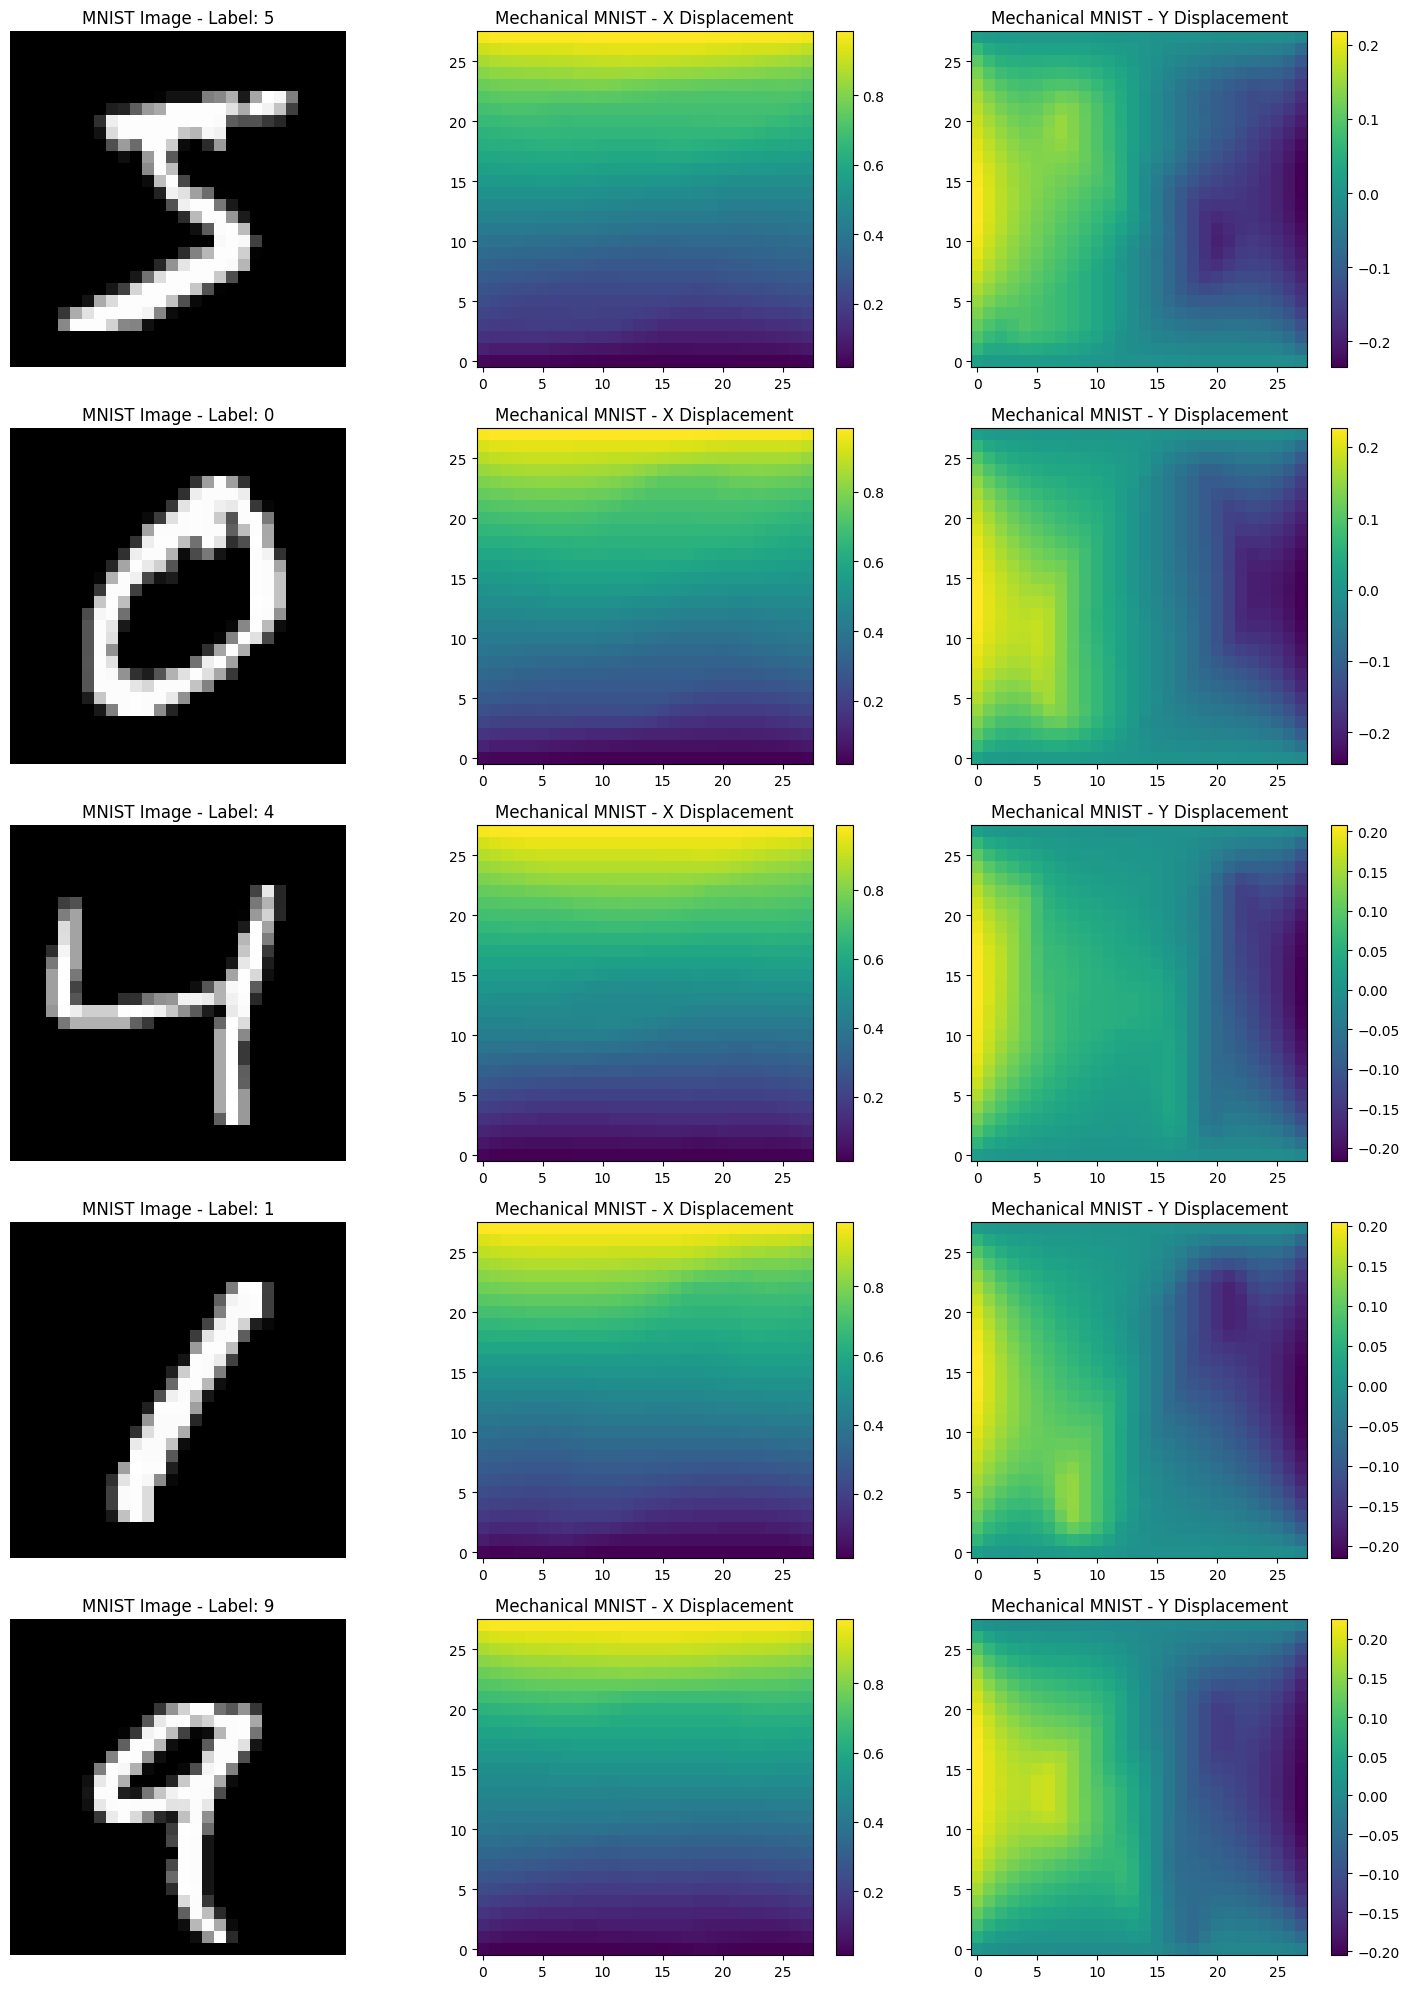

In [6]:
import matplotlib.pyplot as plt

# visualize first 5 pics
def visualize_samples(mnist_data, mech_data, labels, num_samples=5):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 4))

    for i in range(num_samples):
        axes[i, 0].imshow(mnist_data[i].reshape(28, 28), cmap='gray')
        axes[i, 0].set_title(f'MNIST Image - Label: {labels[i]}')
        axes[i, 0].axis('off')

        im1 = axes[i, 1].imshow(mech_data[i, 0, :, :], cmap='viridis', origin='lower')
        axes[i, 1].set_title('Mechanical MNIST - X Displacement')
        fig.colorbar(im1, ax=axes[i, 1])

        im2 = axes[i, 2].imshow(mech_data[i, 1, :, :], cmap='viridis', origin='lower')
        axes[i, 2].set_title('Mechanical MNIST - Y Displacement')
        fig.colorbar(im2, ax=axes[i, 2])

    plt.tight_layout()
    plt.show()

# first 5
mnist_train_subset = mnist_train[:5]
mnist_mech_train_subset = mnist_mech_train[:5]
y_train_subset = y_train[:5]

visualize_samples(mnist_train_subset, mnist_mech_train_subset, y_train_subset)

## On the basis of the physical experiment, explain why the displacement images look the way they look.
According to the picture, we can clearly see that in the y direction, "impression" is produced due to writing, which reflects the shape of the number itself, but it is not very clear;

In the x direction, since the effect applied in the test is that the lower fixes the upper shears, the gradient change from the bottom to the top in the figure is generated, and its distribution is not completely uniform due to the influence of the handwriting

# Constructing CNN-based Classifiers

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

class CombinedCNN(nn.Module):
    def __init__(self, input_channels=1):
        super(CombinedCNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(256 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 256 * 3 * 3)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Given that the input image is of size 28 × 28, what will be the size of the intermediate tensors after each layer of the above CNN?

after conv1: (32, 28, 28)

after pool1: (32, 14, 14)

after conv2: (128, 14, 14)

after pool2: (128, 7, 7)

after conv3: (256, 7, 7)

after pool3: (256, 3, 3)

# Training and Testing

## Training

In [8]:
from tqdm import tqdm

def train_model(model, train_loader, optimizer, criterion, num_epochs=30):
    model.train()
    batch_losses = []
    batch_accuracies = []
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        correct = 0
        total = 0
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
            if len(labels.shape) > 1:
                labels = labels.view(-1)

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # loss of batch
            batch_losses.append(loss.item())
            running_loss += loss.item()

            # acc of batch
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            batch_accuracy = 100 * correct / total
            batch_accuracies.append(batch_accuracy)

        # avg loss and acc of epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)

        epoch_accuracy = 100 * correct / total
        epoch_accuracies.append(epoch_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    return batch_losses, batch_accuracies, epoch_losses, epoch_accuracies

In [9]:
model_mnist = CombinedCNN(input_channels=1).to(device)
model_mech_mnist = CombinedCNN(input_channels=2).to(device)

criterion = nn.CrossEntropyLoss()

optimizer_mnist = optim.Adam(model_mnist.parameters(), weight_decay=1e-5)
optimizer_mech_mnist = optim.Adam(model_mech_mnist.parameters(), weight_decay=1e-5)

In [10]:
mnist_batch_losses, mnist_batch_accuracies, mnist_epoch_losses, mnist_epoch_accuracies = train_model(
    model_mnist, train_loader_mnist, optimizer_mnist, criterion
)
mech_batch_losses, mech_batch_accuracies, mech_epoch_losses, mech_epoch_accuracies = train_model(
    model_mech_mnist, train_loader_mech_mnist, optimizer_mech_mnist, criterion
)

Epoch [1/30], Loss: 0.3127, Accuracy: 94.13%


Epoch [2/30], Loss: 0.0436, Accuracy: 98.61%


Epoch [3/30], Loss: 0.0334, Accuracy: 98.93%


Epoch [4/30], Loss: 0.0259, Accuracy: 99.14%


Epoch [5/30], Loss: 0.0255, Accuracy: 99.22%


Epoch [6/30], Loss: 0.0208, Accuracy: 99.32%


Epoch [7/30], Loss: 0.0214, Accuracy: 99.33%


Epoch [8/30], Loss: 0.0187, Accuracy: 99.41%


Epoch [9/30], Loss: 0.0166, Accuracy: 99.49%


Epoch [10/30], Loss: 0.0143, Accuracy: 99.56%


Epoch [11/30], Loss: 0.0173, Accuracy: 99.50%


Epoch [12/30], Loss: 0.0153, Accuracy: 99.52%


Epoch [13/30], Loss: 0.0152, Accuracy: 99.55%


Epoch [14/30], Loss: 0.0136, Accuracy: 99.59%


Epoch [15/30], Loss: 0.0109, Accuracy: 99.68%


Epoch [16/30], Loss: 0.0125, Accuracy: 99.67%


Epoch [17/30], Loss: 0.0140, Accuracy: 99.61%


Epoch [18/30], Loss: 0.0163, Accuracy: 99.56%


Epoch [19/30], Loss: 0.0084, Accuracy: 99.75%


Epoch [20/30], Loss: 0.0135, Accuracy: 99.62%


Epoch [21/30], Loss: 0.0103, Accuracy: 99.72%


Epoch [22/30], Loss: 0.0098, Accuracy: 99.75%


Epoch [23/30], Loss: 0.0157, Accuracy: 99.63%


Epoch [24/30], Loss: 0.0106, Accuracy: 99.72%


Epoch [25/30], Loss: 0.0100, Accuracy: 99.77%


Epoch [26/30], Loss: 0.0086, Accuracy: 99.80%


Epoch [27/30], Loss: 0.0112, Accuracy: 99.73%


Epoch [28/30], Loss: 0.0138, Accuracy: 99.68%


Epoch [29/30], Loss: 0.0063, Accuracy: 99.82%


Epoch [30/30], Loss: 0.0120, Accuracy: 99.70%


Epoch [1/30], Loss: 1.0347, Accuracy: 63.88%


Epoch [2/30], Loss: 0.3769, Accuracy: 87.35%


Epoch [3/30], Loss: 0.2512, Accuracy: 91.78%


Epoch [4/30], Loss: 0.1923, Accuracy: 93.78%


Epoch [5/30], Loss: 0.1657, Accuracy: 94.64%


Epoch [6/30], Loss: 0.1491, Accuracy: 95.12%


Epoch [7/30], Loss: 0.1343, Accuracy: 95.66%


Epoch [8/30], Loss: 0.1195, Accuracy: 96.09%


Epoch [9/30], Loss: 0.1104, Accuracy: 96.48%


Epoch [10/30], Loss: 0.1021, Accuracy: 96.73%


Epoch [11/30], Loss: 0.0969, Accuracy: 96.91%


Epoch [12/30], Loss: 0.0893, Accuracy: 97.14%


Epoch [13/30], Loss: 0.0812, Accuracy: 97.36%


Epoch [14/30], Loss: 0.0775, Accuracy: 97.54%


Epoch [15/30], Loss: 0.0718, Accuracy: 97.78%


Epoch [17/30], Loss: 0.0617, Accuracy: 97.98%


Epoch [18/30], Loss: 0.0594, Accuracy: 98.11%


Epoch [19/30], Loss: 0.0571, Accuracy: 98.17%


Epoch [20/30], Loss: 0.0532, Accuracy: 98.22%


Epoch [21/30], Loss: 0.0517, Accuracy: 98.30%


Epoch [22/30], Loss: 0.0469, Accuracy: 98.47%


Epoch [23/30], Loss: 0.0453, Accuracy: 98.53%


Epoch [24/30], Loss: 0.0455, Accuracy: 98.46%


Epoch [25/30], Loss: 0.0408, Accuracy: 98.66%


Epoch [26/30], Loss: 0.0381, Accuracy: 98.73%


Epoch [27/30], Loss: 0.0369, Accuracy: 98.76%


Epoch [28/30], Loss: 0.0349, Accuracy: 98.83%


Epoch [29/30], Loss: 0.0342, Accuracy: 98.86%


Epoch [30/30], Loss: 0.0322, Accuracy: 98.92%


### Plot loss versus iteration & Plot the accuracy versus iteration

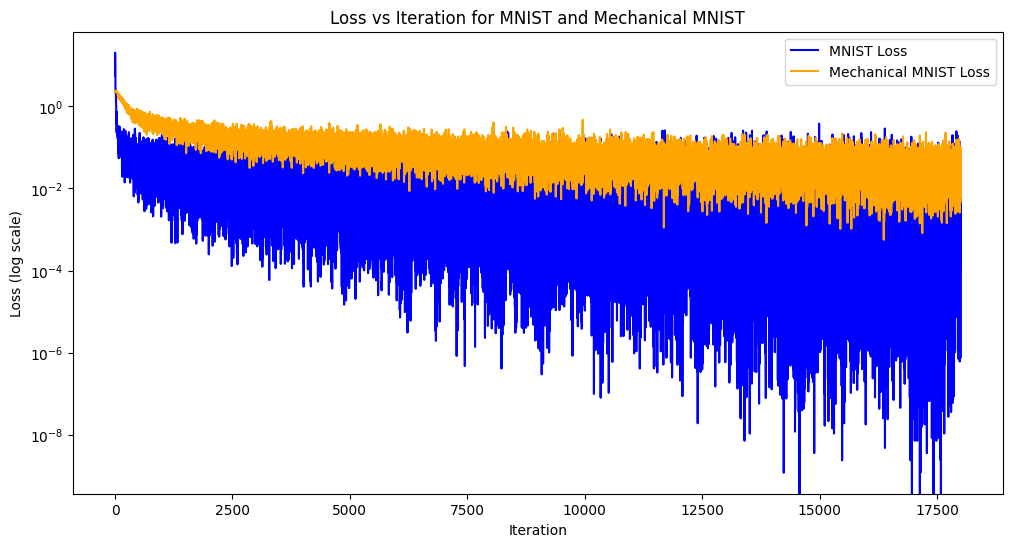

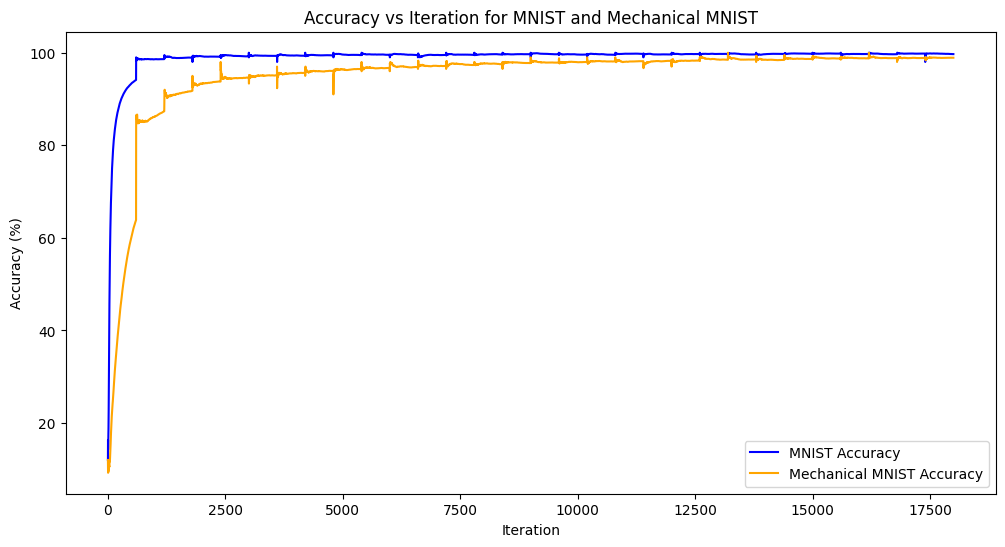

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# plot loss using log
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(mnist_batch_losses)), mnist_batch_losses, label='MNIST Loss', color='blue')
plt.plot(np.arange(len(mech_batch_losses)), mech_batch_losses, label='Mechanical MNIST Loss', color='orange')
plt.yscale('log')  # log
plt.xlabel('Iteration')
plt.ylabel('Loss (log scale)')
plt.title('Loss vs Iteration for MNIST and Mechanical MNIST')
plt.legend()
plt.show()

# plot acc not using log
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(mnist_batch_accuracies)), mnist_batch_accuracies, label='MNIST Accuracy', color='blue')
plt.plot(np.arange(len(mech_batch_accuracies)), mech_batch_accuracies, label='Mechanical MNIST Accuracy', color='orange')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Iteration for MNIST and Mechanical MNIST')
plt.legend()
plt.show()

### What do you observe?

(1) With continuous iteration, both kinds of data train the model well, while the the MNIST set is faster

(2) The accuracy fluctuates slightly at the start of each new epoch

## Testing

In [12]:
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    errors = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # save errors
            incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]
            if len(incorrect_indices) > 0:
                for idx in incorrect_indices:
                    errors.append({
                        'input': inputs[idx].cpu().numpy(),
                        'predicted': predicted[idx].item(),
                        'actual': labels[idx].item()
                    })

    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

    return avg_loss, accuracy, errors

In [13]:
mnist_test_loss, mnist_test_accuracy, mnist_errors = test_model(model_mnist, test_loader_mnist, criterion)

mech_mnist_test_loss, mech_mnist_test_accuracy, mech_errors = test_model(model_mech_mnist, test_loader_mech_mnist, criterion)

Test Loss: 0.0743, Test Accuracy: 98.77%
Test Loss: 0.0664, Test Accuracy: 98.10%


MNIST does better.

I guess this is because the data in the X direction basically doesn't have strong relation with the labels, which leads to ineffective training, so the convergence speed of Mech training is slower than MNIST

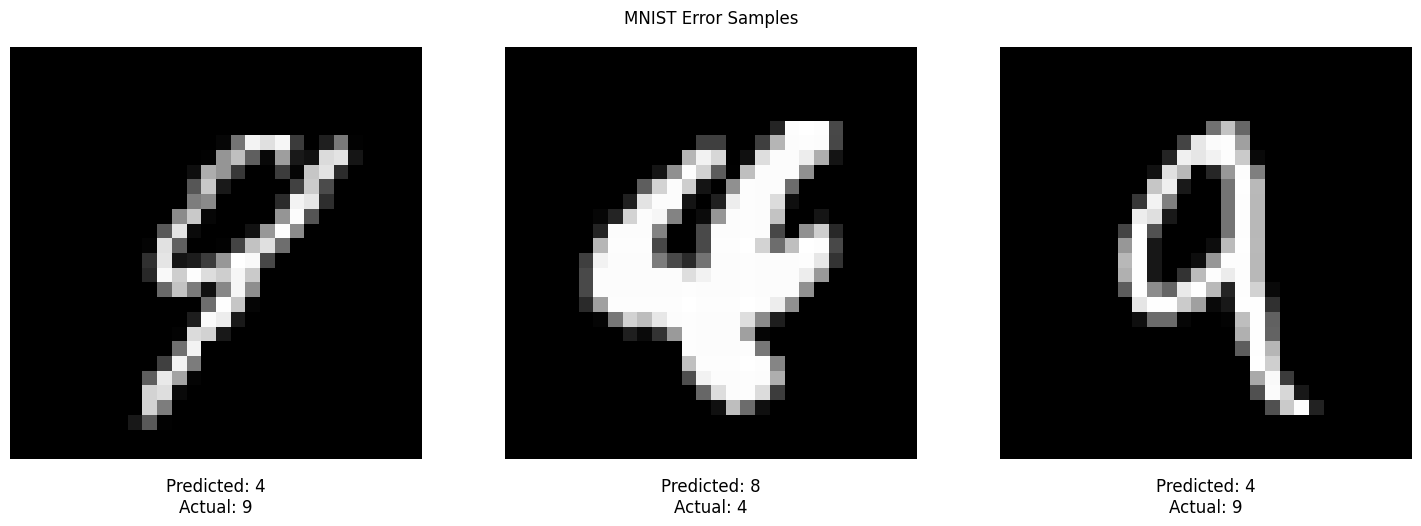

In [14]:
import matplotlib.pyplot as plt

# plot MNIST errors
def plot_mnist_error_samples(errors, title="MNIST Error Samples", num_samples=3):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i, error in enumerate(errors[:num_samples]):
        img = error['input'].reshape(28, 28)
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Predicted: {error['predicted']}\nActual: {error['actual']}", y=-0.15)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_mnist_error_samples(mnist_errors, title="MNIST Error Samples")

The misrecognized numbers are not properly written.

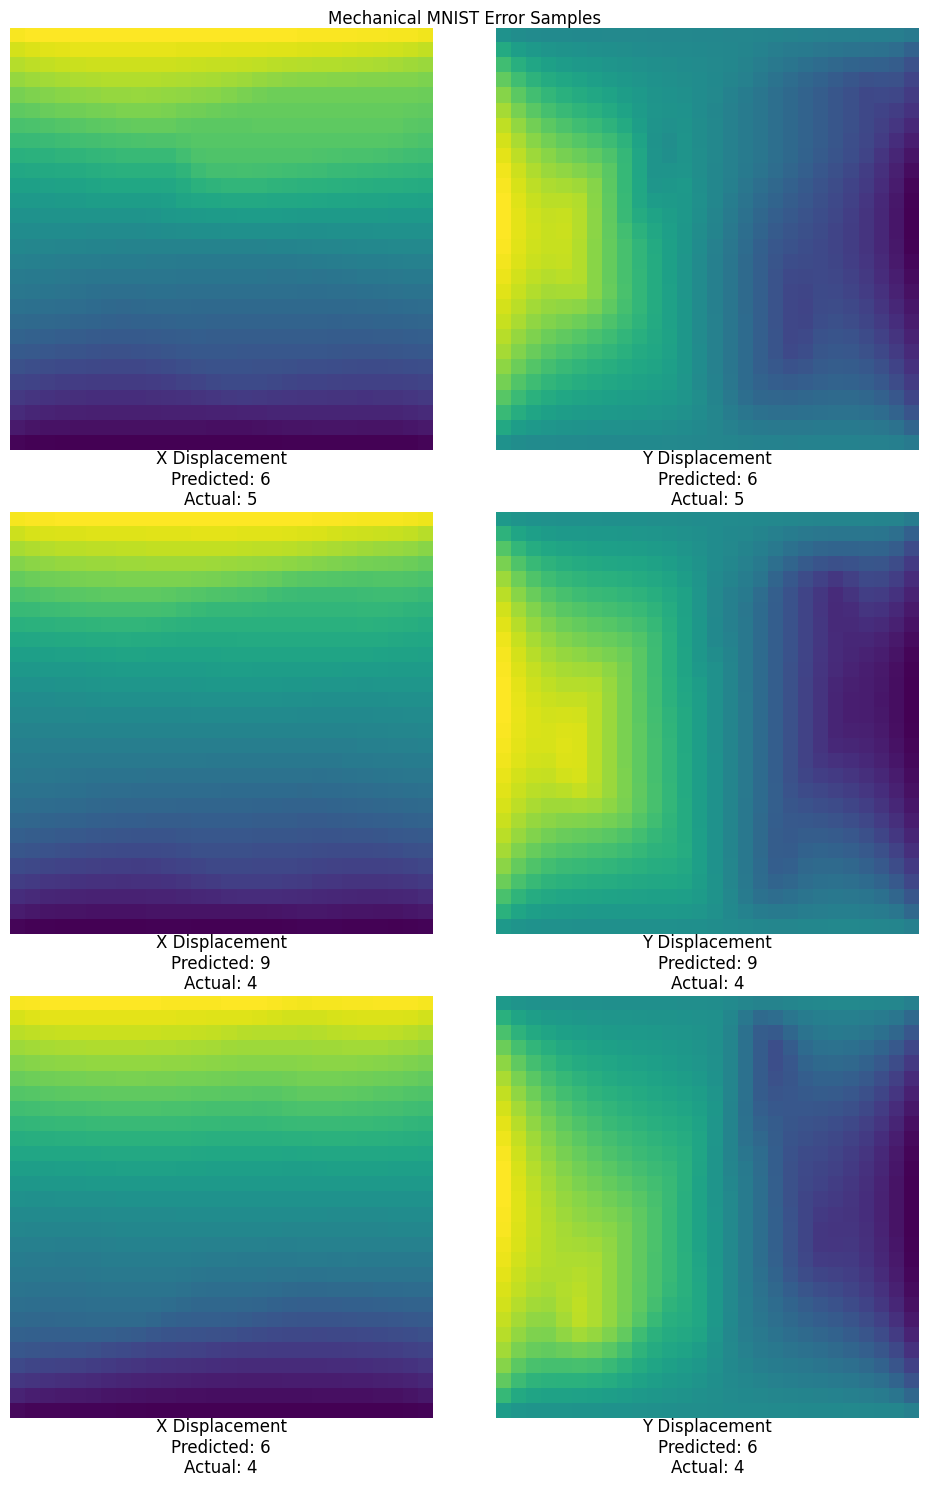

In [15]:
import matplotlib.pyplot as plt

# plot Mech errors
def plot_mech_error_samples(errors, title="Mechanical MNIST Error Samples", num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))

    for i, error in enumerate(errors[:num_samples]):
        img_x = error['input'][0].reshape(28, 28)
        axes[i, 0].imshow(img_x, cmap='viridis', origin='lower')
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"X Displacement\nPredicted: {error['predicted']}\nActual: {error['actual']}", y=-0.15)

        img_y = error['input'][1].reshape(28, 28)
        axes[i, 1].imshow(img_y, cmap='viridis', origin='lower')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Y Displacement\nPredicted: {error['predicted']}\nActual: {error['actual']}", y=-0.15)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_mech_error_samples(mech_errors, title="Mechanical MNIST Error Samples")

Like MNIST, it is also a problem of non-standard writing